# PDP and ICE Plots

Ref:<br>
<a href="https://www.kaggle.com/code/dansbecker/partial-dependence-plots/notebook">Partial Dependence Plots</a><br>
<a href="https://christophm.github.io/interpretable-ml-book/pdp.html">In Depth: Partial Dependence Plots</a>by Chris Molnar<br>
<a href="https://christophm.github.io/interpretable-ml-book/ice.html">In Depth: Individual Conditional Expectation (ICE)</a>by Chris Molnar<br>

This is part of 'Explainable AI', which answers the question 'Why did it do that?'

Both of these are used to plot predicted outputs based on 1 (or at most 2) predictor variables

**Assumptions:** <mark>All columns are independant. The model you use with these algorithms has learned something from the data.  The more it has learned, the more valuable the PDP and ICE plots</mark><br>
**Usage:** PDP and ICE plots can be used for any model since operations are applied only to input data<br>
**What they indicate** How the dependant variable changes based on changes in 1 ((or at most 2) predictor variables<br>

**Kind of questions you can answer with these**<br>
1. Model trained on melborne housing dataset.  Controlling for house characteristics, what impact do longitude and latitude have on home prices? To restate this, we want to understand how similarly sized houses would be priced in different areas, even if the homes actually at these sites are different sizes.

2. Model trained on dataset contains employee info (age, sex, college, years exp, *salary*, etc..). How much of wage differences between men and women are due solely to gender, as opposed to differences in education backgrounds or work experience?

3. Model trained on patient statistical data (age, diet, health, etc.).  Are health differences between two groups due to differences in their diets, or due to other factors?

Given the messiness of most real-world data sources, PDP plots are a good sanity check that your model is capturing realistic patterns.


**ICE plots:**<br>
1.Choose a column to analyze. Permute those columns through expected range of values while holding all other columns Constant!.  Record the predicted result.<br>
2.Plot the permuted column values verses predicted result<br>
3.repeat steps 1 and 2 for slecetd (or all) rows in dataset.<br>

**PDP plots**<br>
Take the average of all ICE plots and plot.
 
A quote from <a href="https://christophm.github.io/interpretable-ml-book/pdp.html">Interpretable Machine Learning</a> by Christoph Molnar, 
*The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value. In my experience, lay people usually understand the idea of PDPs quickly.*<br>
*<mark>If the feature for which you computed the PDP is not correlated with the other features, then the PDPs perfectly represent how the feature influences the prediction on average. In the uncorrelated case, the interpretation is clear: The partial dependence plot shows how the average prediction in your dataset changes when the j-th feature is changed.</mark>*
 <!--The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value.-->



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# Get Data

In [15]:
from sklearn.inspection import partial_dependence,plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.impute import SimpleImputer

#use only the numeric columns
cols_to_use = ['Rooms','Distance','Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 
                        'YearBuilt', 'Lattitude', 'Longtitude']

def get_some_data():
    data = pd.read_feather("../datasets/melb_data_cleaned.feather")
    y = data.Price
    X = data[cols_to_use]
    # my_imputer = SimpleImputer()
    # imputed_X = my_imputer.fit_transform(X)
    return X, y
    

X, y = get_some_data()

# Get a model and train

In [26]:
from sklearn.ensemble import RandomForestRegressor

# feature_names = X.columns
model = RandomForestRegressor(oob_score=True,random_state=42)
_=model.fit(X, y)

# print(f'model.oob_score_={model.oob_score_}')

# Try sklearns PDP and ICE plots

## PDP

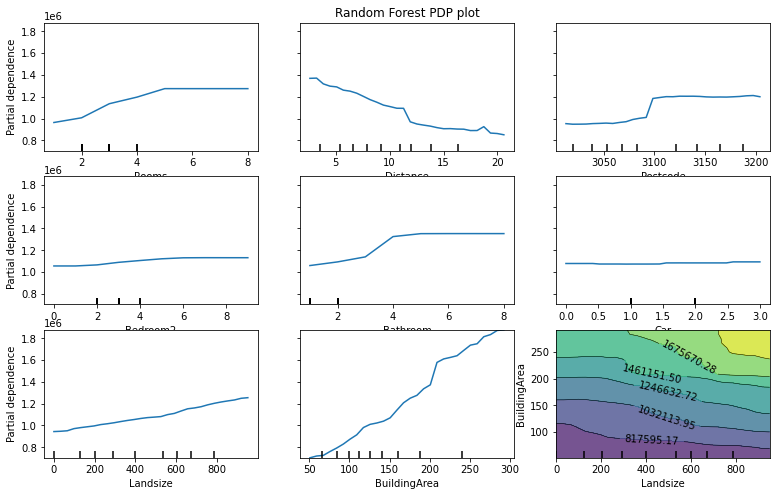

In [84]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Random Forest PDP plot")
my_plots = PartialDependenceDisplay.from_estimator(model, 
                                   features=[0,1,2,3,4,5,6,7,(6,7)], 
                                   X=X, 
                                   feature_names=cols_to_use, 
                                   grid_resolution=30, ax=ax)

In [73]:
#If you need the raw values of the partial dependence function rather than the plots, 
#you can use the sklearn.inspection.partial_dependence function:
from sklearn.inspection import partial_dependence
pdp, axes = partial_dependence(model, X, [3])#get the 3rd feature

## ICE
If your dataset is large, plot a subset, otherwise you cannot see individual lines

In [74]:
#sample, then clean up index
Xs=X.sample( n=40, replace=False, weights=None, random_state=42).reset_index(drop=True)
print(f'there are {len(Xs)} rows in Xs')

there are 40 rows in Xs


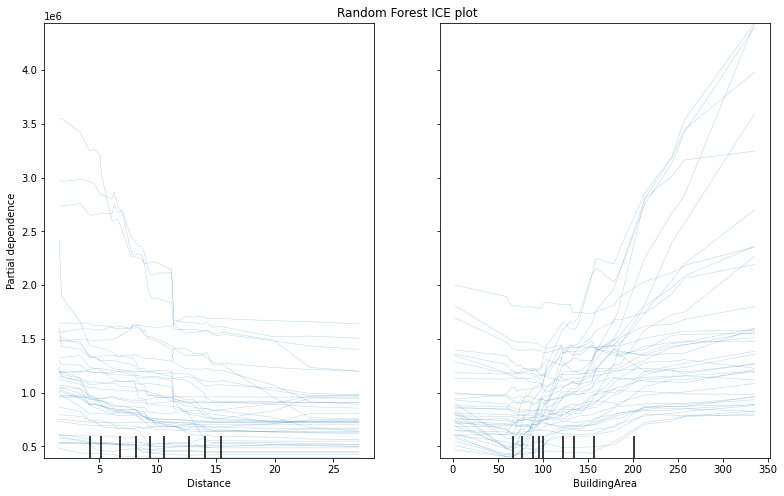

In [78]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Random Forest ICE plot")
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(model, Xs, features=[1,7],kind='individual', ax=ax)

# Lets try 3D plots
see <a href="https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py">this page</a> for more information
<!--possibly not maintained PDP package See <a href="https://pdpbox.readthedocs.io/en/latest/papers.html">PDPBox</a> for documentation-->

array([ 51.        ,  77.77777778, 104.55555556, 131.33333333,
       158.11111111, 184.88888889, 211.66666667, 238.44444444,
       265.22222222, 292.        ])

<Axes3D:>

Text(0.5, 0, 'Distance')

Text(0.5, 0.5, 'BuildingArea')

Text(0.5, 0, 'Partial dependence')

Text(0.5, 0.98, 'Partial dependence of house value on Rooms\nand BuildingArea')

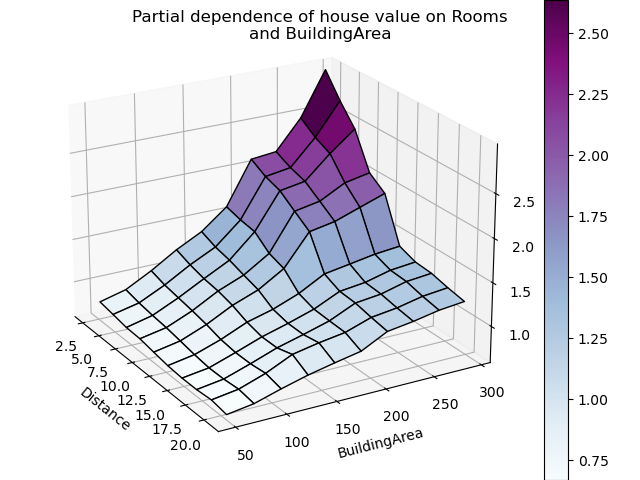

In [100]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

# features = ("AveOccup", "HouseAge")
pdp = partial_dependence(
    model, X, features=[1,7], kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(cols_to_use[1])
ax.set_ylabel(cols_to_use[7])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=-30)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of house value on " + cols_to_use[0] +"\n"
    "and " + cols_to_use[7]
)
plt.subplots_adjust(top=0.9)
plt.show()


In [59]:
# !conda install -c conda-forge pdpbox -y

# from pdpbox import pdp

# # Create the data that we will plot
# pdp_goals = pdp.pdp_isolate(model=model, dataset=X, model_features=cols_to_use, feature='BuildingArea')

# # plot it
# pdp.pdp_plot(pdp_goals, 'Building Area')
# plt.show()

# # Create the data that we will plot
# pdp_goals = pdp.pdp_isolate(model=model, dataset=X, model_features=cols_to_use, feature='Distance')

# # plot it
# pdp.pdp_plot(pdp_goals, 'Distance')
# plt.show()